## Presentation Types:  Fuga, ID, and PEN with Verovio

#### Updated July 2022**


* This function uses several other functions to classify the entries in a given piece.

#### Key Features
* The output is a list, in order of offset, of each presentation type, including information about:
    - measures/beats
    - starting offset
    - **soggetti** involved (set the length of the soggetti with `melodic_ngram_length`, by default this is set to **4**, and uses diatonic intervals)
    - **melodic intervals** between successive entries (expressed as directed intervals, such as `P-5, P-8`)
    - **time intervals** between successive entries (expressed as offsets, like `8.0, 4.0, 8.0`)
    - **Labels Fuga, PEn, and ID** according to time intervals between entries. NIm not yet supported.
    - Reports **voice names of the entries**, in order of their appearance
    
#### Singletons, Long Gaps, and Parallel Entries

* Other features include:

    - Singleton soggetti (just one entry of a given motive in isolation) are not reported
    - If two entries are separated by more than about 9 bars (70 offsets), the tool resets to a new pattern
    - Identifies **Parallel Entries** in any passage.  If two voices enter at the same offset (normally in parallel thirds or tenths), the function will attempt to identify the voice that follows (or preceeds) other, non-parallel voices at the interval P1, P4, P5, P8, or P12 (which are more typical).  If neither of the parallel voices aligns with other parts in this way, the tool takes the upper-most voice as the real entry.  The parallel voice is removed from the pattern data, but the name of the voice is stored in another column (**Parallel Voice**).
    - Identifies the number of **Non Overlapping Entries** and reports the count in a separate column
      
#### Unisons, Flexes, and Hidden Entries
* In addition, the latest version of the tool offers a number of other important features:
     - **combine unisons** in the melodies under comparison (default = False).  This can be especially helpful when comparing different compositions based on the same model.
     - allow **melodic flexes** among the matching soggetti included in any particular event.  The flexing can be focused on the **first interval** with `flex_threshold` (default = 1), or permitted in any position with `edit_distance_threshold` (default = 0). The latter are determined via a side-by-side comparison of all soggetti:  the threshold determines the cumulative difference among all successive intervals in each pair.  The presence of **flexed entries** is reported in a separate column, and all matching soggetti are reported in the soggetti column as a list.
     - the option to find **hidden PENs and IDs** among longer Fugas.  Set to false by default, passing `include_hidden_types=True` will instead consider **every combination** of voices in each Fuga, identifying sets of three or four voices that form PEns and IDs.  Both the complete pattern and the hidden patterns will be reported.
     
#### Verovio Rendering of Excerpts
     
* It is also possible to display the results of the Presentation Type classifier in the Notebook with Verovio. Each excerpt lasts from the first bar of the first entry through four bars after the start of the last entry.

The function also displays metadata about each excerpt, drawn from the presentation type results dataframe: piece ID, composer, title, measures, presentation type, beat of the bar in which the final tone is heard, and evaded status.

To use the function, pass the piece, cadence data frame, url of the piece, and mei_file name (all loaded in the first part of this notebook) as follows:

`verovio_print_presentation_types(piece, presentation_types, url, mei_file)`

Each of the arguments for this function has been created in the process of building the presentation type data frame.

In [1]:
import intervals
from intervals import * 
from intervals import main_objs
import pandas as pd
import re
import os
import numpy
import itertools
# import collections
MYDIR = ("saved_csv")
CHECK_FOLDER = os.path.isdir(MYDIR)

# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)
    print("created folder : ", MYDIR)

else:
    print(MYDIR, "folder already exists.")

saved_csv folder already exists.


#### Load the Piece Here

* Note that you can load from CRIM, or put a file in the **Music_Files** folder in the Notebook.

In [2]:
prefix = 'https://crimproject.org/mei/'
# just add the CRIM Piece ID here
mei_file = 'CRIM_Model_0001.mei'
url = prefix + mei_file

piece = importScore(url)


print(piece.metadata)


Successfully imported https://crimproject.org/mei/CRIM_Model_0001.mei
{'title': 'Veni speciosam', 'composer': 'Johannes Lupi'}


## Find Presentation Types
* `piece.presentationTypes()`

- limit to entries (following rests or section) = `limit_to_entries = True`.
- allowing 'moving window' of all patterns in every voice = `limit_to_entries = False`
- set the length of the soggetti with `melodic_ngram_length = n`
- set flexed threshold for first interval `flex_threshold=1`
- set the maximum difference between similar soggetti with `edit_distance_threshold = n`
- to include all the hidden PENs and IDS (those found within longer Fugas, use `include_hidden_types = True`.  
- for faster (and simpler) listing of points of imitation without hidden forms, use `include_hidden_types = False`

* For example:

`piece.presentationTypes(limit_to_entries = True,
                            flex_threshold=1,
                        edit_distance_threshold = 0,
                        include_hidden_types = False,
                        combine_unisons = True,
                       melodic_ngram_length = 4)`
                       
                       
* Read the documentation:  `print(piece.presentationTypes.__doc__)`

In [3]:
p_types = piece.presentationTypes(limit_to_entries = True,
                        edit_distance_threshold = 0,
                        flex_threshold=1,
                        include_hidden_types = False,
                        combine_unisons = False,
                       melodic_ngram_length = 4)


In [4]:
p_types.head(5)

Composer           Title  First_Offset  \
0  Johannes Lupi  Veni speciosam           0.0   
1  Johannes Lupi  Veni speciosam          94.0   
2  Johannes Lupi  Veni speciosam         138.0   
3  Johannes Lupi  Veni speciosam         226.0   
4  Johannes Lupi  Veni speciosam         314.0   

                                      Measures_Beats  \
0        [1/1.0, 2/3.0, 5/1.0, 6/3.0, 9/2.0, 10/1.0]   
1                                   [12/4.0, 16/4.0]   
2  [18/2.0, 18/4.0, 19/4.0, 20/4.0, 21/2.0, 24/2....   
3  [29/2.0, 30/3.0, 31/2.0, 31/3.0, 34/4.0, 35/2....   
4           [40/2.0, 41/2.0, 43/2.0, 43/4.0, 45/2.0]   

           Melodic_Entry_Intervals  \
0          [P-4, P-5, P-4, P4, P8]   
1                             [P4]   
2  [P-4, P4, P5, P5, M-9, P-4, P4]   
3      [P-4, P8, P-4, P4, P5, P-8]   
4               [P8, P-12, m9, M7]   

                                             Offsets  \
0                [0.0, 12.0, 32.0, 44.0, 66.0, 72.0]   
1                                      [94.0, 126.0]   
2  [138.0, 142.0, 150.0, 158.0, 162.0, 186.0, 190...   
3  [226.0, 236.0, 242.0, 244.0, 270.0, 274.0, 290.0]   
4                [314.0, 322.0, 338.0, 342.0, 354.0]   

                         Soggetti                  Time_Entry_Intervals  \
0  [(5, -2, 2, 3), (4, -2, 2, 3)]         [12.0, 20.0, 12.0, 22.0, 6.0]   
1                [(-3, 2, 2, -2)]                                [32.0]   
2                [(-2, -3, 2, 2)]  [4.0, 8.0, 8.0, 4.0, 24.0, 4.0, 8.0]   
3  [(5, -2, 2, 3), (4, -2, 2, 3)]     [10.0, 6.0, 2.0, 26.0, 4.0, 16.0]   
4                 [(2, -3, 2, 3)]                [8.0, 16.0, 4.0, 12.0]   

                                              Voices Presentation_Type  \
0  [Superius, Contratenor, PrimusTenor, Bassus, S...              FUGA   
1                                   [Bassus, Bassus]              FUGA   
2  [PrimusTenor, Bassus, SecundusTenor, Contraten...              FUGA   
3  [PrimusTenor, Bassus, Superius, SecundusTenor,...              FUGA   
4  [Bassus, Superius, Bassus, Contratenor, Superius]              FUGA   

   Number_Entries  Flexed_Entries  Parallel_Entries Parallel_Voice  \
0               6            True               0.0           None   
1               2           False               0.0           None   
2               8           False               0.0           None   
3               7            True               0.0           None   
4               5           False               0.0           None   

   Count_Non_Overlaps  
0                   0  
1                   1  
2                   0  
3                   0  
4                   0

## Render Excerpts with Verovio

`verovio_print_ptypes(piece, p_types, url, mei_file)`

Each of these items has been set in the process of creating the dataframe above.

Results:
MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 1-14
Presentation Type:  FUGA
Voices:  ['Superius', 'Contratenor', 'PrimusTenor', 'Bassus', 'SecundusTenor', 'Superius']
Number of Entries:  6
Main Soggetto:  ('5', '-2', '2', '3')
Melodic Entry Intervals:  ['P-4', 'P-5', 'P-4', 'P4', 'P8']
Time Entry Intervals:  [12.0, 20.0, 12.0, 22.0, 6.0]
Flexed:  True
Parallel Entries: None
Number of Non-Overlapping Voices: 0


[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported data.PERCENT '100'
[Warning] Unsupported '<line>' within <measure>
[Warning] Unsupported '<line>' within <measure>


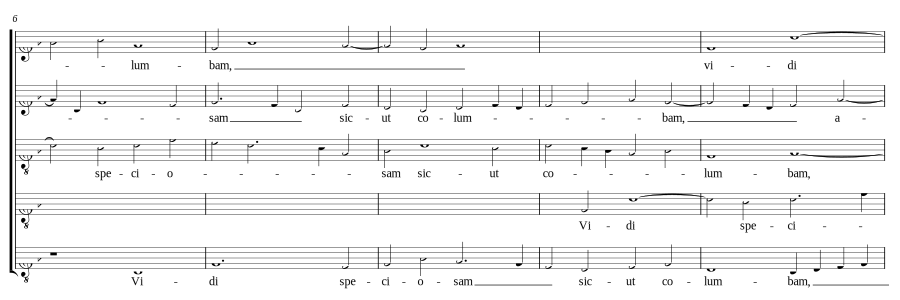

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 12-20
Presentation Type:  FUGA
Voices:  ['Bassus', 'Bassus']
Number of Entries:  2
Main Soggetto:  ('-3', '2', '2', '-2')
Melodic Entry Intervals:  ['P4']
Time Entry Intervals:  [32.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 1


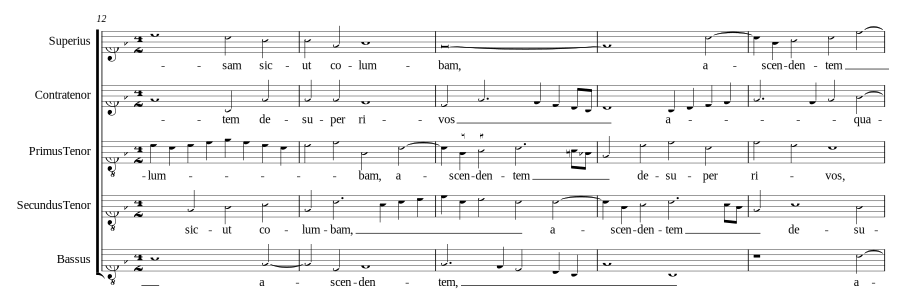

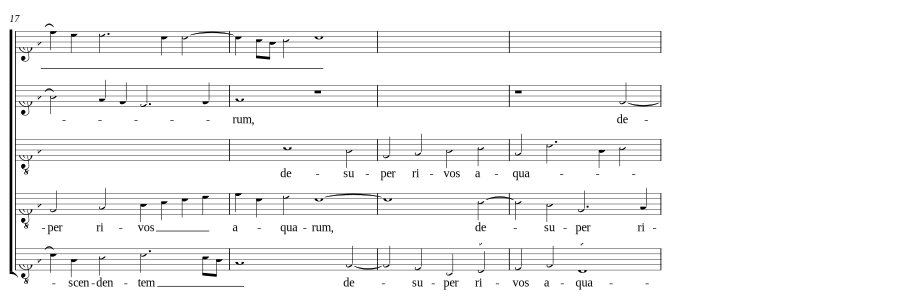

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 18-29
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'Bassus', 'SecundusTenor', 'Contratenor', 'Superius', 'PrimusTenor', 'Bassus', 'SecundusTenor']
Number of Entries:  8
Main Soggetto:  ('-2', '-3', '2', '2')
Melodic Entry Intervals:  ['P-4', 'P4', 'P5', 'P5', 'M-9', 'P-4', 'P4']
Time Entry Intervals:  [4.0, 8.0, 8.0, 4.0, 24.0, 4.0, 8.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


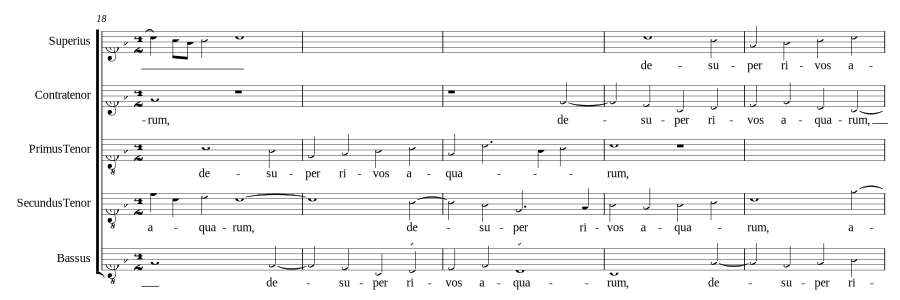

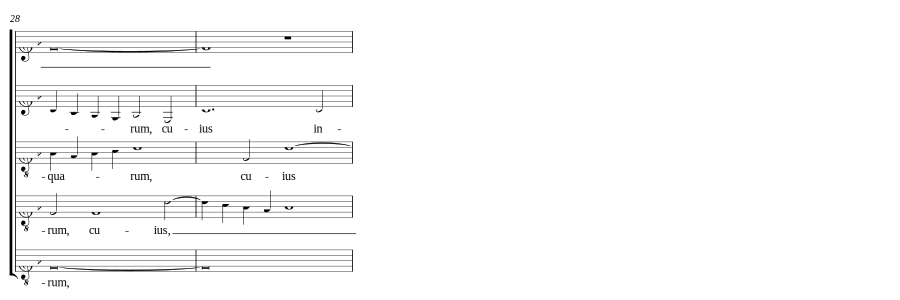

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 29-41
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'Bassus', 'Superius', 'SecundusTenor', 'Contratenor', 'Superius', 'PrimusTenor']
Number of Entries:  7
Main Soggetto:  ('5', '-2', '2', '3')
Melodic Entry Intervals:  ['P-4', 'P8', 'P-4', 'P4', 'P5', 'P-8']
Time Entry Intervals:  [10.0, 6.0, 2.0, 26.0, 4.0, 16.0]
Flexed:  True
Parallel Entries: None
Number of Non-Overlapping Voices: 0


MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 40-49
Presentation Type:  FUGA
Voices:  ['Bassus', 'Superius', 'Bassus', 'Contratenor', 'Superius']
Number of Entries:  5
Main Soggetto:  ('2', '-3', '2', '3')
Melodic Entry Intervals:  ['P8', 'P-12', 'm9', 'M7']
Time Entry Intervals:  [8.0, 16.0, 4.0, 12.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 41-50
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'SecundusTenor', 'PrimusTenor', 'SecundusTenor']
Number of Entries:  4
Main Soggetto:  ('2', '-3', '2', '4')
Melodic Entry Intervals:  ['P-4', 'M-2', 'P5']
Time Entry Intervals:  [6.0, 20.0, 12.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


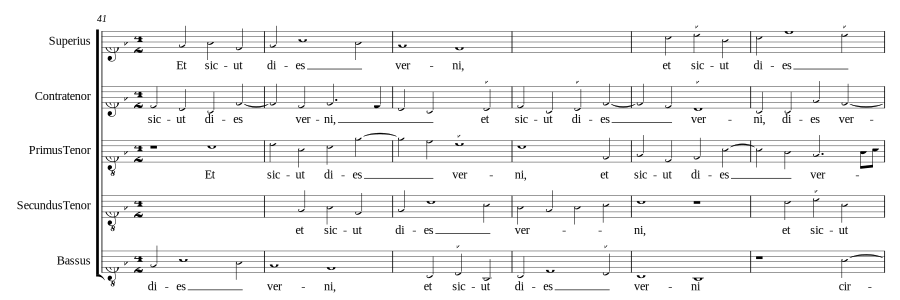

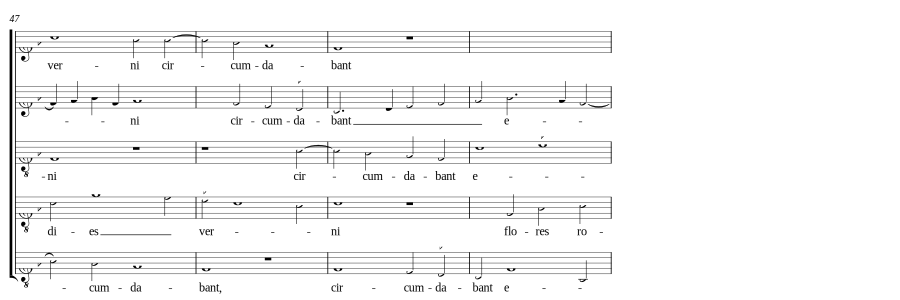

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 50-58
Presentation Type:  FUGA
Voices:  ['SecundusTenor', 'PrimusTenor', 'SecundusTenor', 'Bassus']
Number of Entries:  4
Main Soggetto:  ('3', '2', '-3', '-2')
Melodic Entry Intervals:  ['P5', 'P1', 'P-8']
Time Entry Intervals:  [12.0, 12.0, 10.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


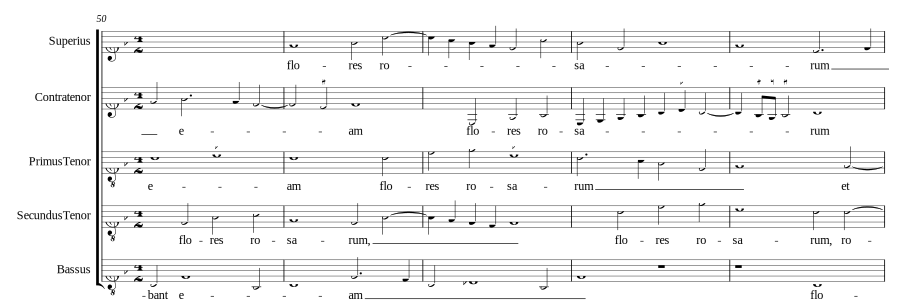

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 54-69
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'Contratenor', 'Superius', 'Bassus', 'PrimusTenor', 'SecundusTenor', 'Bassus', 'PrimusTenor', 'Bassus', 'PrimusTenor']
Number of Entries:  10
Main Soggetto:  ('4', '1', '-2', '2')
Melodic Entry Intervals:  ['P4', 'P5', 'M-9', 'P5', 'P-4', 'P-5', 'P4', 'P-5', 'P5']
Time Entry Intervals:  [4.0, 8.0, 16.0, 4.0, 16.0, 12.0, 2.0, 22.0, 4.0]
Flexed:  True
Parallel Entries: None
Number of Non-Overlapping Voices: 0


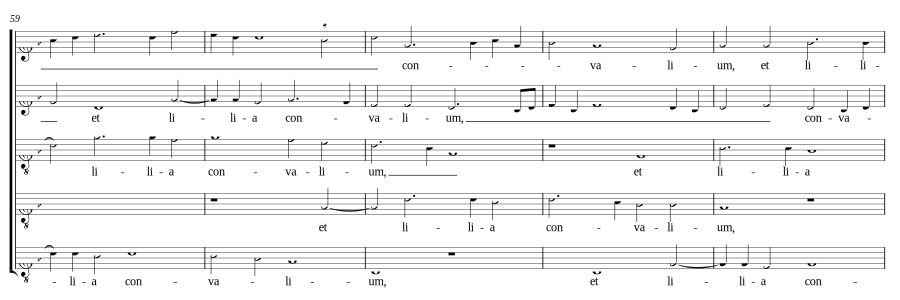

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 74-87
Presentation Type:  FUGA
Voices:  ['Superius', 'Contratenor', 'SecundusTenor', 'Bassus', 'Superius', 'PrimusTenor']
Number of Entries:  6
Main Soggetto:  ('3', '-2', '-2', '-2')
Melodic Entry Intervals:  ['P-5', 'P-4', 'P-5', 'P12', 'P-8']
Time Entry Intervals:  [12.0, 32.0, 12.0, 12.0, 4.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 85-98
Presentation Type:  FUGA
Voices:  ['Contratenor', 'SecundusTenor', 'Superius', 'Bassus', 'Contratenor', 'Superius']
Number of Entries:  6
Main Soggetto:  ('-3', '2', '2', '2')
Melodic Entry Intervals:  ['P-5', 'P8', 'P-11', 'P8', 'P1']
Time Entry Intervals:  [16.0, 6.0, 22.0, 6.0, 24.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


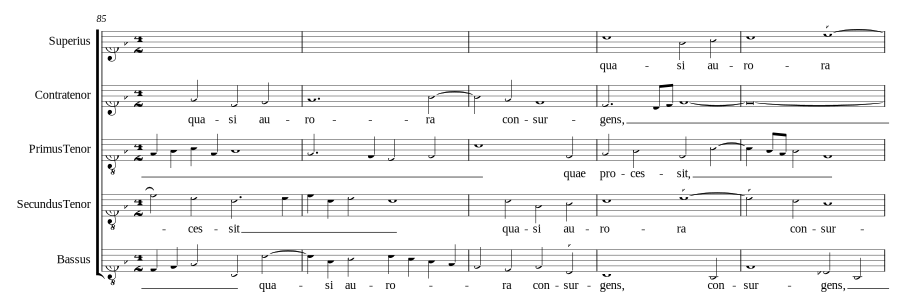

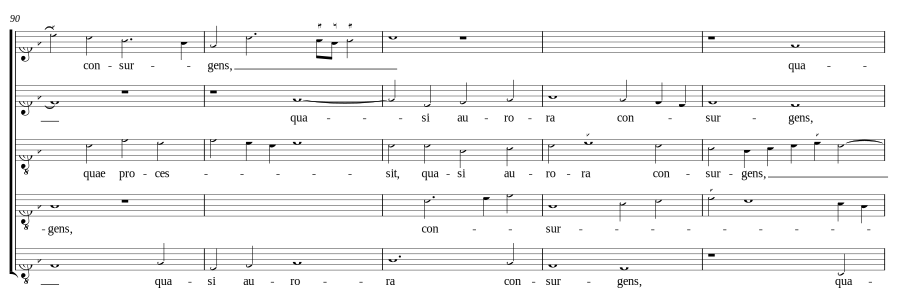

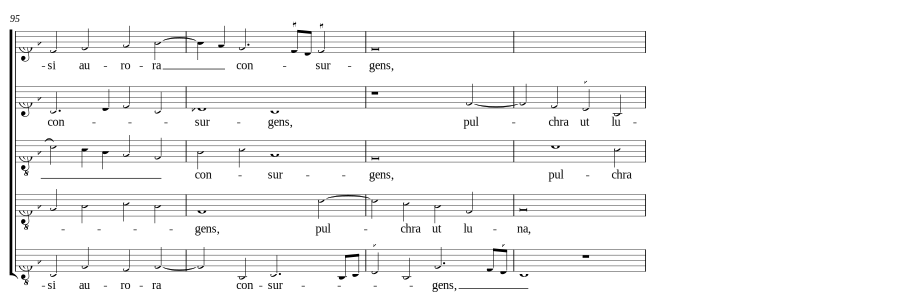

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 96-106
Presentation Type:  FUGA
Voices:  ['SecundusTenor', 'Contratenor', 'PrimusTenor', 'Superius', 'Bassus', 'SecundusTenor', 'Bassus']
Number of Entries:  7
Main Soggetto:  ('-2', '-2', '-3', '2')
Melodic Entry Intervals:  ['P4', 'P-4', 'P8', 'P-12', 'P4', 'M2']
Time Entry Intervals:  [8.0, 4.0, 8.0, 8.0, 8.0, 12.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


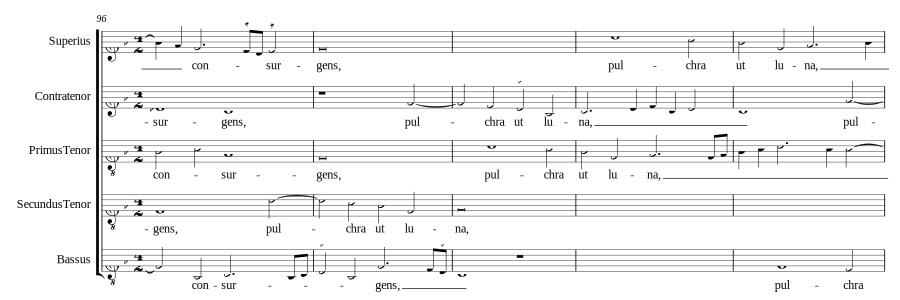

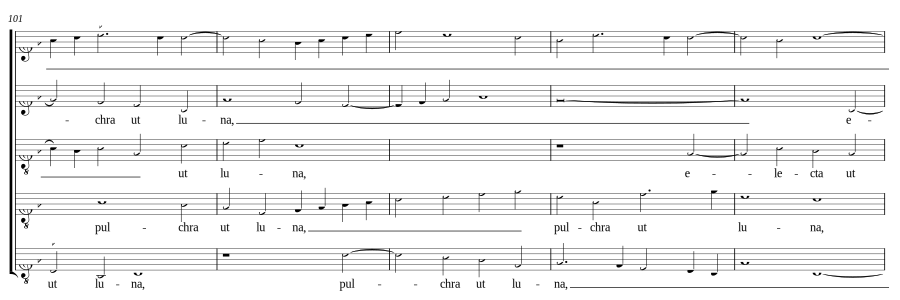

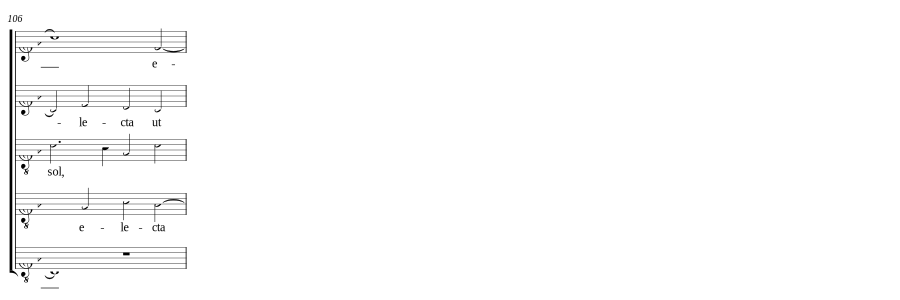

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 104-114
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'Contratenor', 'PrimusTenor', 'SecundusTenor']
Number of Entries:  4
Main Soggetto:  ('3', '-2', '-2', '4')
Melodic Entry Intervals:  ['P4', 'P1', 'P1']
Time Entry Intervals:  [8.0, 24.0, 12.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


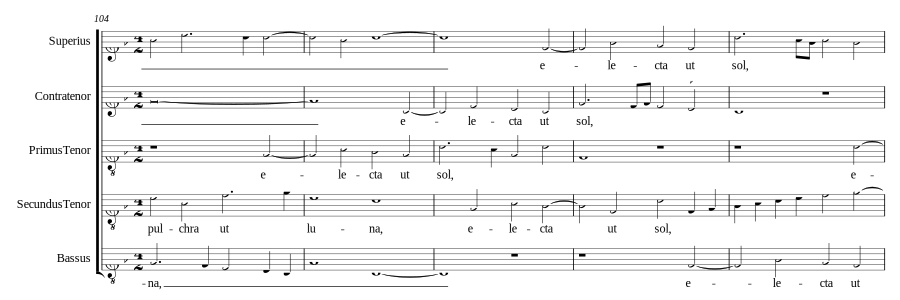

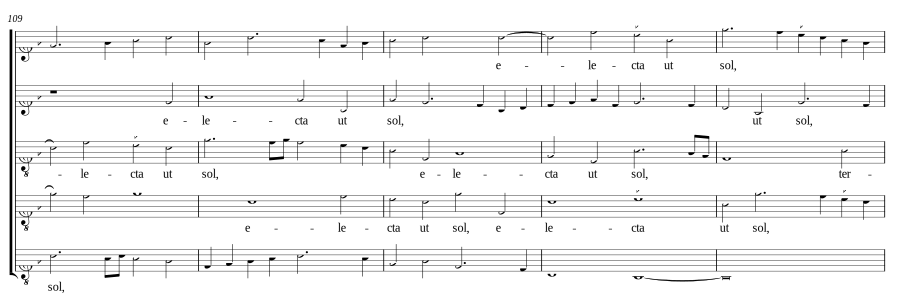

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 106-115
Presentation Type:  FUGA
Voices:  ['SecundusTenor', 'Superius']
Number of Entries:  2
Main Soggetto:  ('3', '-2', '-3', '5')
Melodic Entry Intervals:  ['P11']
Time Entry Intervals:  [44.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 1


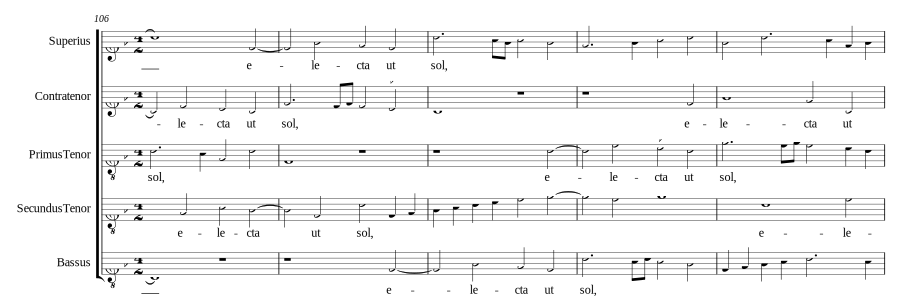

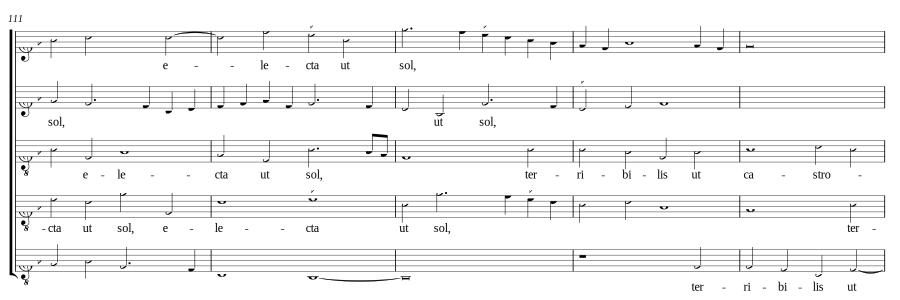

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 106-111
Presentation Type:  FUGA
Voices:  ['Superius', 'Bassus']
Number of Entries:  2
Main Soggetto:  ('3', '-2', '-2', '5')
Melodic Entry Intervals:  ['P-8']
Time Entry Intervals:  [8.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


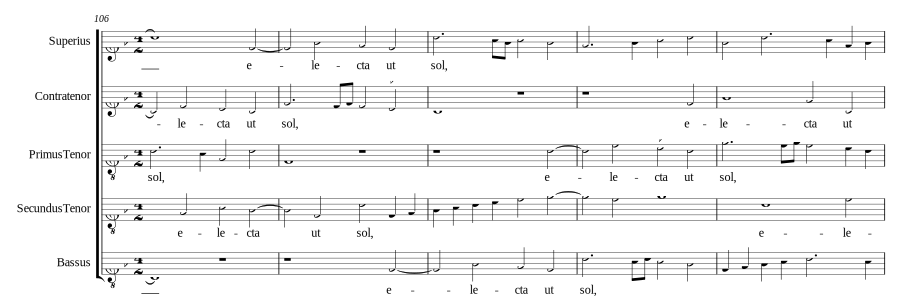

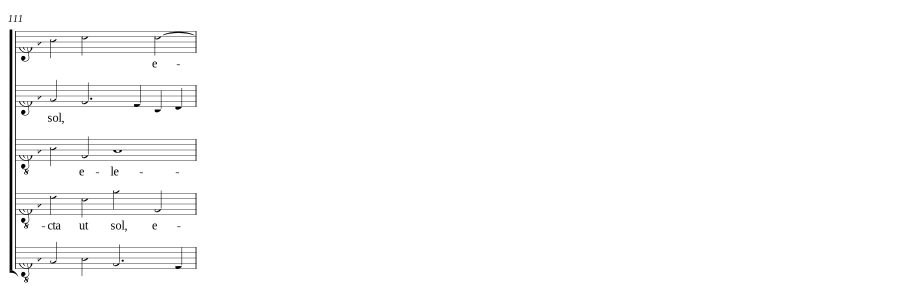

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 113-123
Presentation Type:  FUGA
Voices:  ['PrimusTenor', 'Bassus', 'Contratenor', 'Superius', 'Bassus']
Number of Entries:  5
Main Soggetto:  ('1', '-2', '-3', '3')
Melodic Entry Intervals:  ['P-4', 'P8', 'P5', 'P-8']
Time Entry Intervals:  [8.0, 12.0, 8.0, 20.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


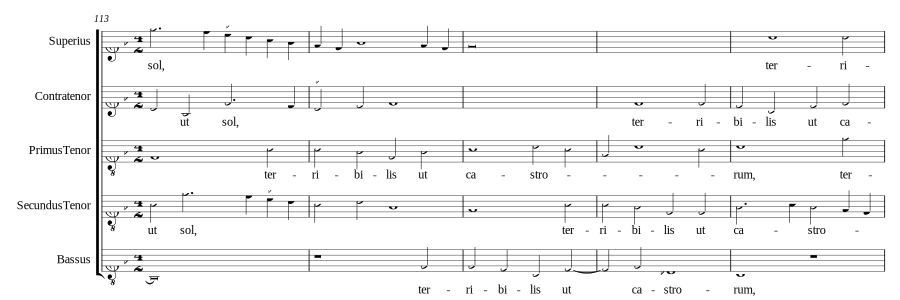

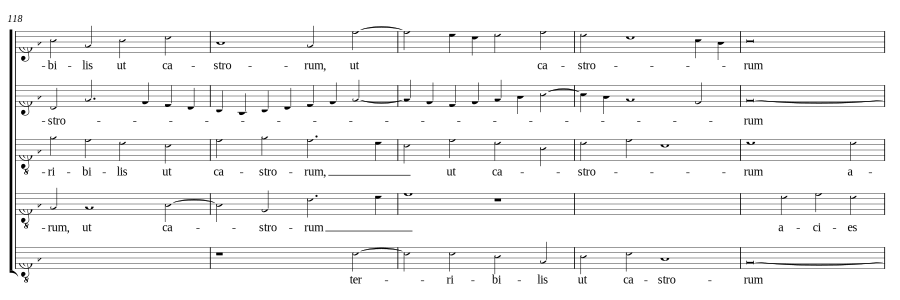

MEI File:  CRIM_Model_0001.mei
Johannes Lupi
Veni speciosam
Measures: 122-133
Presentation Type:  FUGA
Voices:  ['SecundusTenor', 'PrimusTenor', 'Superius', 'Contratenor', 'SecundusTenor', 'Bassus', 'Contratenor', 'SecundusTenor']
Number of Entries:  8
Main Soggetto:  ('2', '-2', '-3', '2')
Melodic Entry Intervals:  ['P1', 'P8', 'P-5', 'P-5', 'P-8', 'P8', 'P1']
Time Entry Intervals:  [4.0, 4.0, 14.0, 14.0, 6.0, 10.0, 8.0]
Flexed:  False
Parallel Entries: None
Number of Non-Overlapping Voices: 0


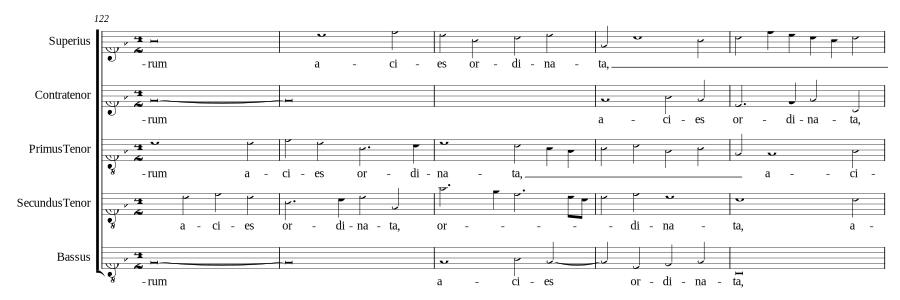

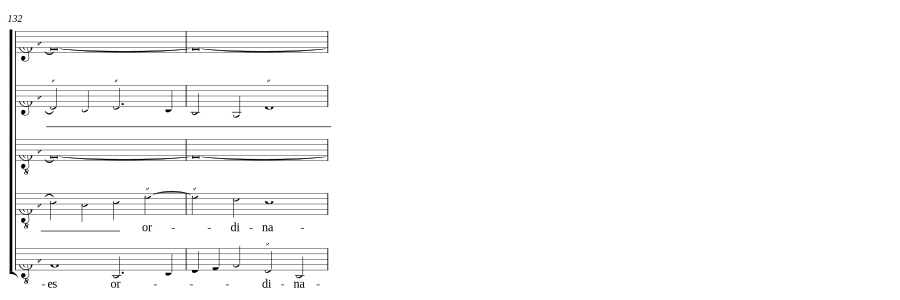

In [5]:
verovio_print_ptypes(piece, p_types, url, mei_file)

## Find Presentation Types in Several Pieces at Once

* Results are combined into a single dataframe
* Set thresholds and other features as noted above

* Read the documentation:  `print(CorpusBase.batch.__doc__)`

In [22]:

corpus = CorpusBase(['https://crimproject.org/mei/CRIM_Mass_0006_1.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0006_2.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0006_3.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0006_4.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0006_5.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0007_1.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0007_2.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0007_3.mei',
                     'https://crimproject.org/mei/CRIM_Mass_0007_4.mei', 
                     'https://crimproject.org/mei/CRIM_Mass_0007_5.mei',
                             'https://crimproject.org/mei/CRIM_Model_0009.mei'])

Successfully imported https://crimproject.org/mei/CRIM_Mass_0006_1.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0006_2.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0006_3.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0006_4.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0006_5.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0007_1.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0007_2.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0007_3.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0007_4.mei
Successfully imported https://crimproject.org/mei/CRIM_Mass_0007_5.mei
Successfully imported https://crimproject.org/mei/CRIM_Model_0009.mei


In [24]:
func = ImportedPiece.presentationTypes
list_of_dfs = corpus.batch(func=func, kwargs={'edit_distance_threshold' : 0,
                        'flex_threshold': 1,
                        'include_hidden_types' : False,
                        'combine_unisons' : True,
                       'melodic_ngram_length' : 4}, metadata=True)
combined_df = pd.concat(list_of_dfs, ignore_index=False)


In [25]:
combined_df

Composer                                Title  First_Offset  \
0        Jean Guyon      Missa Je suis déshéritée: Kyrie          44.0   
1        Jean Guyon      Missa Je suis déshéritée: Kyrie         124.0   
2        Jean Guyon      Missa Je suis déshéritée: Kyrie         134.0   
3        Jean Guyon      Missa Je suis déshéritée: Kyrie         182.0   
4        Jean Guyon      Missa Je suis déshéritée: Kyrie         254.0   
..              ...                                  ...           ...   
13  Nicolas Gombert  Missa Je suis déshéritée: Agnus Dei         458.0   
0     Pierre Cadéac                   Je suis déshéritée          26.0   
1     Pierre Cadéac                   Je suis déshéritée          34.0   
2     Pierre Cadéac                   Je suis déshéritée         134.0   
3     Pierre Cadéac                   Je suis déshéritée         190.0   

                              Measures_Beats Melodic_Entry_Intervals  \
0            [6/3.0, 10/4.0, 12/3.0, 15/1.0]       [P-15, P15, m-13]   
1                   [15/1.0, 17/3.0, 19/2.0]               [P8, P-8]   
2           [16/2.0, 17/4.0, 21/2.0, 24/1.0]          [P1, P8, P-11]   
3                           [22/2.0, 26/1.0]                    [P8]   
4   [31/2.0, 31/4.0, 32/2.0, 34/1.0, 34/4.0]      [P8, P-12, P5, P1]   
..                                       ...                     ...   
13                          [57/2.0, 61/4.0]                    [P1]   
0                            [4/2.0, 12/2.0]                    [P1]   
1             [5/2.0, 7/2.0, 13/2.0, 15/2.0]           [P8, P-8, P8]   
2                           [17/4.0, 19/2.0]                    [P8]   
3                           [24/4.0, 25/2.0]                    [P8]   

                                Offsets                            Soggetti  \
0             [44.0, 78.0, 92.0, 124.0]                   [(-2, -2, -2, 2)]   
1                 [124.0, 144.0, 158.0]                  [(-2, -2, -2, -2)]   
2          [134.0, 146.0, 174.0, 196.0]                     [(2, 3, -2, 2)]   
3                        [182.0, 212.0]                    [(2, 3, -2, -2)]   
4   [254.0, 258.0, 262.0, 276.0, 282.0]  [(3, -2, -2, -2), (4, -2, -2, -2)]   
..                                  ...                                 ...   
13                       [458.0, 494.0]                     [(-3, 2, 2, 2)]   
0                          [26.0, 90.0]                   [(2, -3, -2, -3)]   
1             [34.0, 50.0, 98.0, 114.0]                   [(-2, -2, -2, 2)]   
2                        [134.0, 146.0]                     [(2, 3, -2, 2)]   
3                        [190.0, 194.0]  [(3, -2, -2, -2), (4, -2, -2, -2)]   

     Time_Entry_Intervals                                             Voices  \
0      [34.0, 14.0, 32.0]       [[Superius], [Bassus], [Superius], [Bassus]]   
1            [20.0, 14.0]                    [[Tenor], [Superius], [Bassus]]   
2      [12.0, 28.0, 22.0]     [[Contratenor], [Tenor], [Superius], [Bassus]]   
3                  [30.0]                              [[Tenor], [Superius]]   
4   [4.0, 4.0, 14.0, 6.0]  [[Tenor], [Superius], [Bassus], [Contratenor],...   
..                    ...                                                ...   
13                 [36.0]                       [[Superius 1], [Superius 1]]   
0                  [64.0]                                   [Bassus, Bassus]   
1      [16.0, 48.0, 16.0]                 [Tenor, Superius, Tenor, Superius]   
2                  [12.0]                                  [Tenor, Superius]   
3                   [4.0]                                  [Tenor, Superius]   

   Presentation_Type  Number_Entries  Flexed_Entries  Parallel_Entries  \
0               FUGA               4           False               0.0   
1               FUGA               3           False               0.0   
2               FUGA               4           False               0.0   
3               FUGA               2           Fals

#### Save to your folder of CSV's here in the Jupyter Hub
#### You can save as CSV, or as Excel.
#### You will then need to download this to your computer to view it properly

* Note that in the following part of the code below, you will need to give your file a name:

`saved_csv/**file_name**.xlsx`

In [26]:
writer = pd.ExcelWriter('saved_csv/file_name.xlsx', engine='xlsxwriter')
points.to_excel(writer, sheet_name='Sheet1')
writer.save()

In [6]:
points.to_csv('saved_csv/your_file_title.csv')